# Laboratory #10 : Vision Transformers

At the end of this laboratory, you would get familiarized with

*   Vision Transformers

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Add sufficient comments and explanations wherever necessary.
*   **Once you have the code completed, use GPU to train model faster.**

---

# **Students** (First Name and Last Name)

1.   Tatevik Davtyan
2.   Eva Veli

---

# Vision Transformers

Vision Transformers were introduced by Alexey Dosovitskiy et al. in the paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)

Read the ViT paper and answer the below descriptive questions.

*   What are the differences between CNN and Transformers?
*   What is Multi-head self-attention?
*   What is Inductive Bias?

**Solution**

One of the main differences between CNNs and Transformers is that CNNs utelize convolutional layers, while transformers utelize attention modules.Another essential difference is that transformers capture long-range dependencies at once as they see the whole context simultaneously while while for CNNs the local receptive fields expand slowly across layers. Also CNNs have a strong inductive bias while Transformers don't, however Transformers require a huge number of data for performing well.

Multi-Head Self-Attention is a module that helps the model to capture important information from different parts of the image at the same time. Since it uses Self-Attention, it computes the relationship between all pairs of input tokens, hence it gets keys, values and queries from the input. Since the module is also multi-head, the output cinsists of several heads, where each head concentrates on a specific concept in the image.

Inductive bias is the assumption/bias that the model has related to the dataset. This means that CNN, which has high inductive bias, are not general models, but attentions are general models and can be used for images, text etc.
...

*   Explain the model architecture of ViT.

**Solution**

As the original Transformers are for NLP tasks, ViT is the adaptation of Transformers for images. Since the standard Transformers use tokens of words, patches are used for the images, and they are flattened to align with the logic of the transformers. Afterwards, projection is applied on each of the flattened patch for obtaining the embedding with our desired length. Afterwards, positional embedding are also added for retain positional information, as embedding by themselve don't contain this information. For classification tasks, a special class token is also concatenated.Afterwards, transformer encoder is applied which consists of MHSA, Layer Normalizations, some residual connections, feed-forward network. Then, the MLP head is applied and the class is predicted.

...

# Introduction

We will implement the Vision Transformer (ViT) model for image classification and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of image patches, without using convolution layers.


In [1]:
import numpy as np
import keras
from keras import layers

import tensorflow as tf  # only for dataloader

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

## Preparing the data

We will use the CIFAR-100 dataset available in tf.keras.datasets package.

In [2]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the Hyper-parameters

In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

## Data Augmentation Pipeline

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## Implement a Multi-layer Perceptron (MLP)

In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implementing Patch Creation Layer

In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

### Visualizing the patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


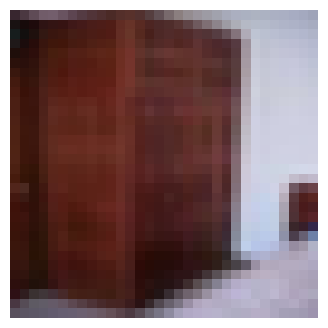

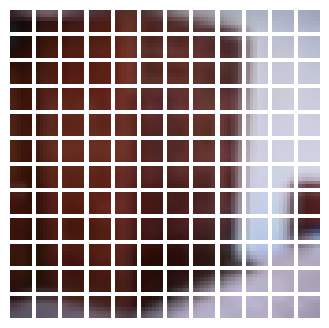

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))

plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Patch Encoding Layer

*   What is the role of Patch Encoding Layer?

**Solution**

Since the the standard Transformers were created for sentences, they require sequences of tokens. To adapt the images for tranformers, the images should be devided into patches and flattened to obtain vectors. Hence from one image we get sequence of flattened tokens and afterwards we can apply patch encoding layer. As mentioned earlier, projection and positional embedding are also used on the patches, which is applied for each of the patch using the patch encoder to embed the patch and add the spatial information.
...

In [8]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

*   What happens in the call function of the PatchEncoder class?

**Solution**

For each of the patch in the batch, the patch is projected into our desired vector shape ( creating an embedding) and positional embedding ( with the same vector shape) is added up to retain the positional/spatial information. Afterwards, the patches are ready to be used in transformers, as each image can be converted into a sequence of transformered  patches.

...

## Building the ViT Model

*   We will use the MultiHeadAttention layer as self-attention for this implementation
*   PS: There are many changes to the original paper for ease of execution

![image](https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png)

In [9]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

*   Explain the execution of the ViT model. What is the sequence of operations?
*   What is skip connection? Why is it needed?

**Solution**

First, the dataset is augmented inasmush as we need mre data because of Transformers. Afterwards, patches are created and encoded. Afterwards, the transformer encoder is applied transformer_layers time, wher layer normalization, MHSA, skipp connections and mlps are used. In the final layers of the whole model, normalization, flattening and dropout, mlp are used ( dropout for avoid overfitting) and dense layer for classification is applied.

A skip connection  is a shortcut path that allows the the learned feature maps of a shallow layer to bypass one or more intermediate layers and be directly added or concatenated to the output of the deep layers.  They tend to tackle the vanishing gradient issue as well as help to retrain the inportante feature information from the shallower layers.
...

*   What is self-attention?
*   What is the problem in using global self-attention?
*   What can be used instead of global self-attention?

**Solution**
Self-Attention is a mechanism that enables a model to focus on different parts of the input simultaneously. Each token attends to every other token in the sequence, enabling the model to capture global relationships of the input image. Hence, query, key and value are obtained from the input itself.

While global self-attention is powerful, it has some significant challenges, particularly with computational efficiency and scalability, as it is computationaly heavy and memory consuming, which is not extremely suitable for the large transformers.

Some alternatives include local self-attention, sparse self-attention, axial attention etc. These attention modules computationally efficient, hence can be used instead of the standard global self-attentions.

...

## Training the ViT Model

In [10]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [11]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 126s 422ms/step - accuracy: 0.0319 - loss: 4.8902 - top-5-accuracy: 0.1195 - val_accuracy: 0.1156 - val_loss: 3.8847 - val_top-5-accuracy: 0.3264
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 133s 433ms/step - accuracy: 0.0900 - loss: 3.9859 - top-5-accuracy: 0.2774 - val_accuracy: 0.1584 - val_loss: 3.6083 - val_top-5-accuracy: 0.4050
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 76s 434ms/step - accuracy: 0.1307 - loss: 3.6996 - top-5-accuracy: 0.3637 - val_accuracy: 0.2028 - val_loss: 3.3398 - val_top-5-accuracy: 0.4708
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 435ms/step - accuracy: 0.1562 - loss: 3.5167 - top-5-accuracy: 0.4198 - val_accuracy: 0.2218 - val_loss: 3.2310 - val_top-5-accuracy: 0.5034
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 435ms/step - accuracy: 0.1868 - loss: 3.3472 - top-5-accuracy: 0.4671 - val_accuracy: 0.2494 - val_loss: 3.0762 - val_top-5-accuracy: 0.5406
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 435ms/step - accuracy: 0.2101

### Creating history plots

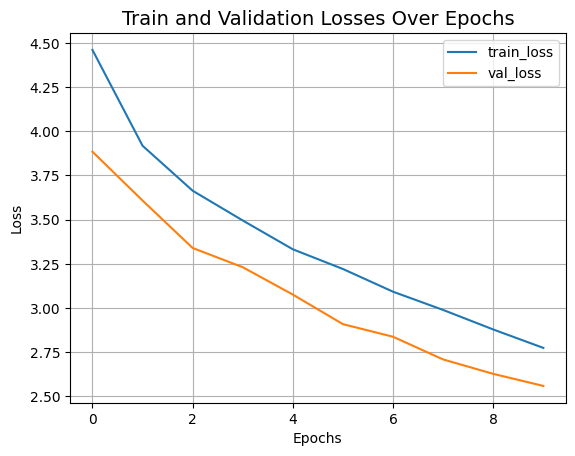

In [12]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

### Evaluating the trained ViT transformer

In [13]:
loss, accuracy, top_5_accuracy = vit_classifier.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.3503 - loss: 2.5239 - top-5-accuracy: 0.6608
Test loss: 2.53
Test accuracy: 34.74%
Test top 5 accuracy: 65.93%


# Shifted Patch Tokenization

In a ViT pipeline, the input images are divided into patches that are then linearly projected into tokens. Shifted patch tokenization (STP) is introduced to combat the low receptive field of ViTs. The steps for Shifted Patch Tokenization are as follows:
*   Start with an image.
*   Shift the image in diagonal directions.
*   Concat the diagonally shifted images with the original image.
*   Extract patches of the concatenated images.
*   Flatten the spatial dimension of all patches.
*   Layer normalize the flattened patches and then project it.

More details about the implementation can be read from the paper [Vision Transformer for Small-Size Datasets](https://arxiv.org/abs/2112.13492v1)

![image](https://i.imgur.com/bUnHxd0.png)

---
*   Implement a shiftedpatchtokenizer class
*   The class should implement the __init__() and call() functions
*   Implement left-up, right-up, left-down and right-down shift operations


In [14]:
# solution
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=image_size,
        patch_size=patch_size,
        num_patches=num_patches,
        projection_dim=projection_dim,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=1e-5)

    def crop_shift_pad(self, images, mode):
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:

            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )

        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:

            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:

            tokens = self.projection(flat_patches)
        return (tokens, patches)



*   Visualize the patches for a random image

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'shifted_patch_tokenization', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


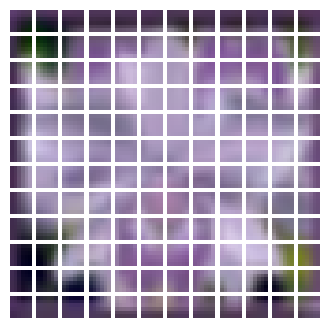

ORIGINAL


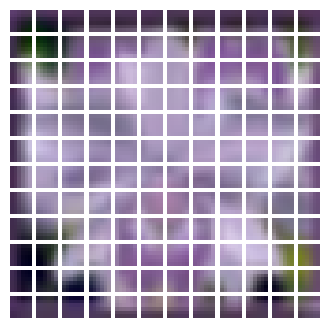

LEFT-UP


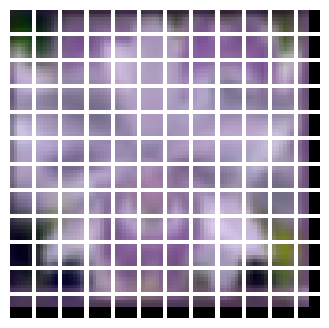

LEFT-DOWN


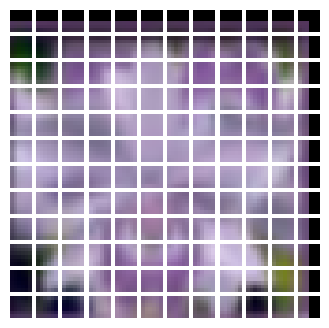

RIGHT-UP


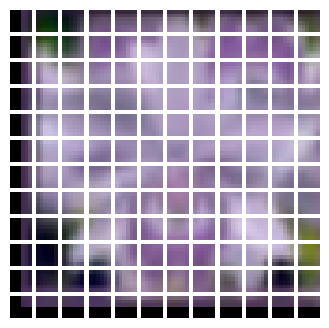

RIGHT-DOWN


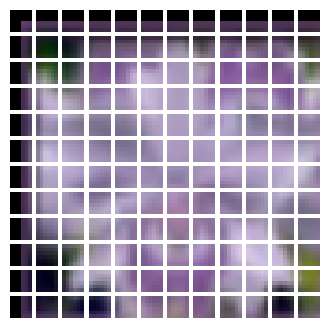

In [15]:
image = x_train[np.random.choice(range(x_train.shape[0]))]
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)


(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = tf.reshape(patch[row][col], (patch_size,patch_size, 3))
        plt.imshow(image)
        plt.axis("off")
plt.show()


(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (patch_size, patch_size, 5 * 3))
            plt.imshow(image[..., 3 * index : 3 * index + 3])
            plt.axis("off")
    plt.show()

## Build the ViT model

*   Create the ViT classifier by replacing the Patch Layer with the Shifted Patch Layer

In [16]:
# solution
diag_attn_mask = 1 - tf.eye(num_patches)
diag_attn_mask = tf.cast([diag_attn_mask], dtype="int8")
def create_vit_classifier_new(vanilla=False):
    inputs = layers.Input(shape=input_shape)

    augmented = data_augmentation(inputs)

    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)

    encoded_patches = PatchEncoder(num_patches, projection_dim)(tokens)


    for _ in range(transformer_layers):

        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        if not vanilla:
            attention_output = layers.MultiHeadAttention(
                num_heads=num_heads, key_dim=projection_dim, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=num_heads, key_dim=projection_dim, dropout=0.1
            )(x1, x1)

        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=inputs, outputs=logits)
    return model



*   Compile and train the classifier

In [17]:
# solution
vit_classifier_new = create_vit_classifier_new()
history_SLP = run_experiment(vit_classifier_new)


Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 114s 471ms/step - accuracy: 0.0314 - loss: 4.8898 - top-5-accuracy: 0.1173 - val_accuracy: 0.1228 - val_loss: 3.8789 - val_top-5-accuracy: 0.3274
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 144s 482ms/step - accuracy: 0.0880 - loss: 4.0237 - top-5-accuracy: 0.2714 - val_accuracy: 0.1694 - val_loss: 3.6240 - val_top-5-accuracy: 0.4104
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 139s 468ms/step - accuracy: 0.1170 - loss: 3.8066 - top-5-accuracy: 0.3343 - val_accuracy: 0.1916 - val_loss: 3.4325 - val_top-5-accuracy: 0.4582
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 144s 478ms/step - accuracy: 0.1473 - loss: 3.6531 - top-5-accuracy: 0.3770 - val_accuracy: 0.2126 - val_loss: 3.3074 - val_top-5-accuracy: 0.4866
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 139s 464ms/step - accuracy: 0.1682 - loss: 3.5184 - top-5-accuracy: 0.4162 - val_accuracy: 0.2348 - val_loss: 3.2012 - val_top-5-accuracy: 0.5162
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 84s 476ms/step - accuracy: 0.1

*   Create the history plot for the new ViT model
*   Evaluate the model using the test set

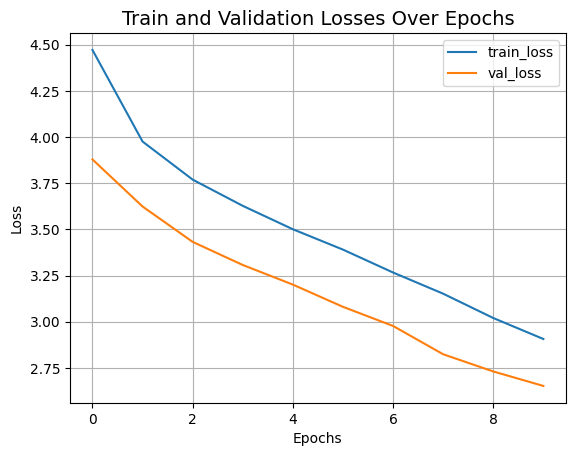

In [18]:
plt.plot(history_SLP.history["loss"], label="train_loss")
plt.plot(history_SLP.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [19]:
loss, accuracy, top_5_accuracy = vit_classifier_new.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.3382 - loss: 2.5982 - top-5-accuracy: 0.6572
Test loss: 2.6
Test accuracy: 34.03%
Test top 5 accuracy: 65.13%


*   Compute confusion matrix and classification summary of both the models
*   Compare both the models with respect to the computed metrics

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step


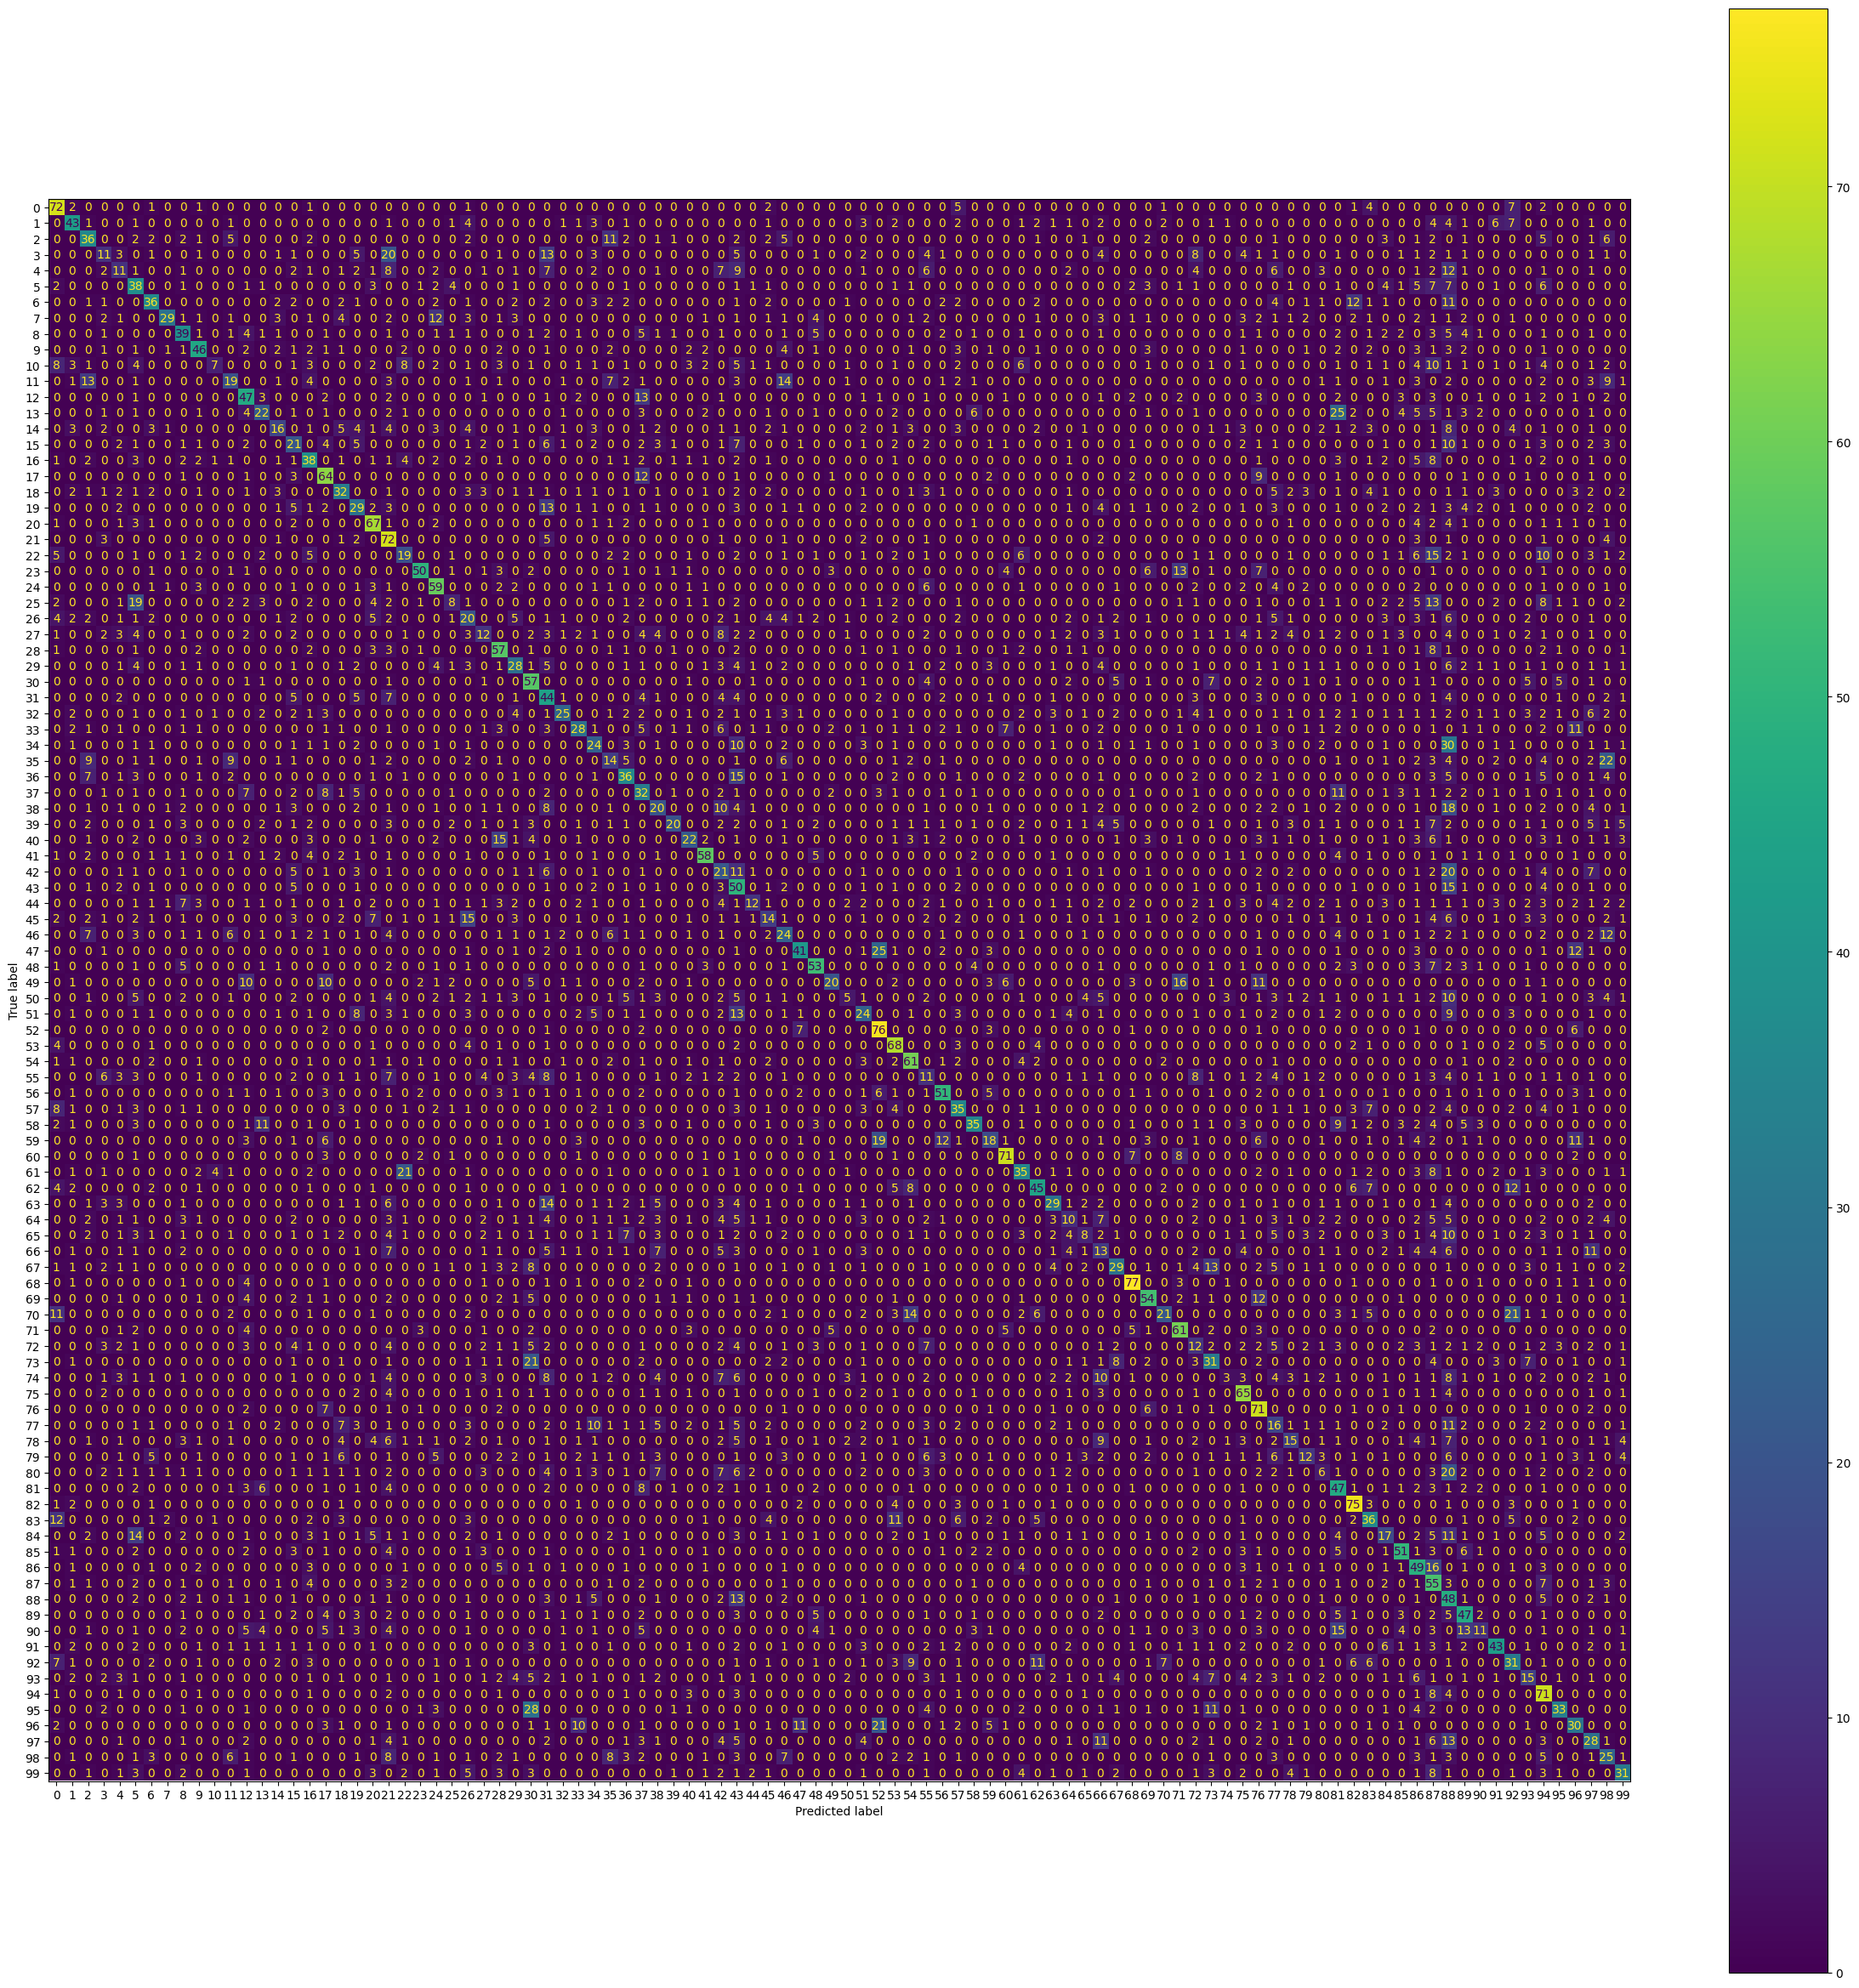

'              precision    recall  f1-score   support\n\n           0       0.46      0.72      0.56       100\n           1       0.51      0.43      0.46       100\n           2       0.35      0.36      0.36       100\n           3       0.20      0.11      0.14       100\n           4       0.17      0.11      0.13       100\n           5       0.23      0.38      0.29       100\n           6       0.45      0.36      0.40       100\n           7       0.76      0.29      0.42       100\n           8       0.37      0.39      0.38       100\n           9       0.51      0.46      0.48       100\n          10       0.50      0.07      0.12       100\n          11       0.28      0.19      0.23       100\n          12       0.37      0.47      0.41       100\n          13       0.34      0.22      0.27       100\n          14       0.35      0.16      0.22       100\n          15       0.21      0.21      0.21       100\n          16       0.37      0.38      0.37       100\n       

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
y_pred = vit_classifier.predict(x_test).argmax(axis=-1)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test.T[0]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test.T[0]))
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(ax=ax)
plt.show()
classification_report(y_test.T[0], y_pred, target_names=list(map(str,np.unique(y_test.T[0]))))

Using Shifted Patch Tokenization
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step


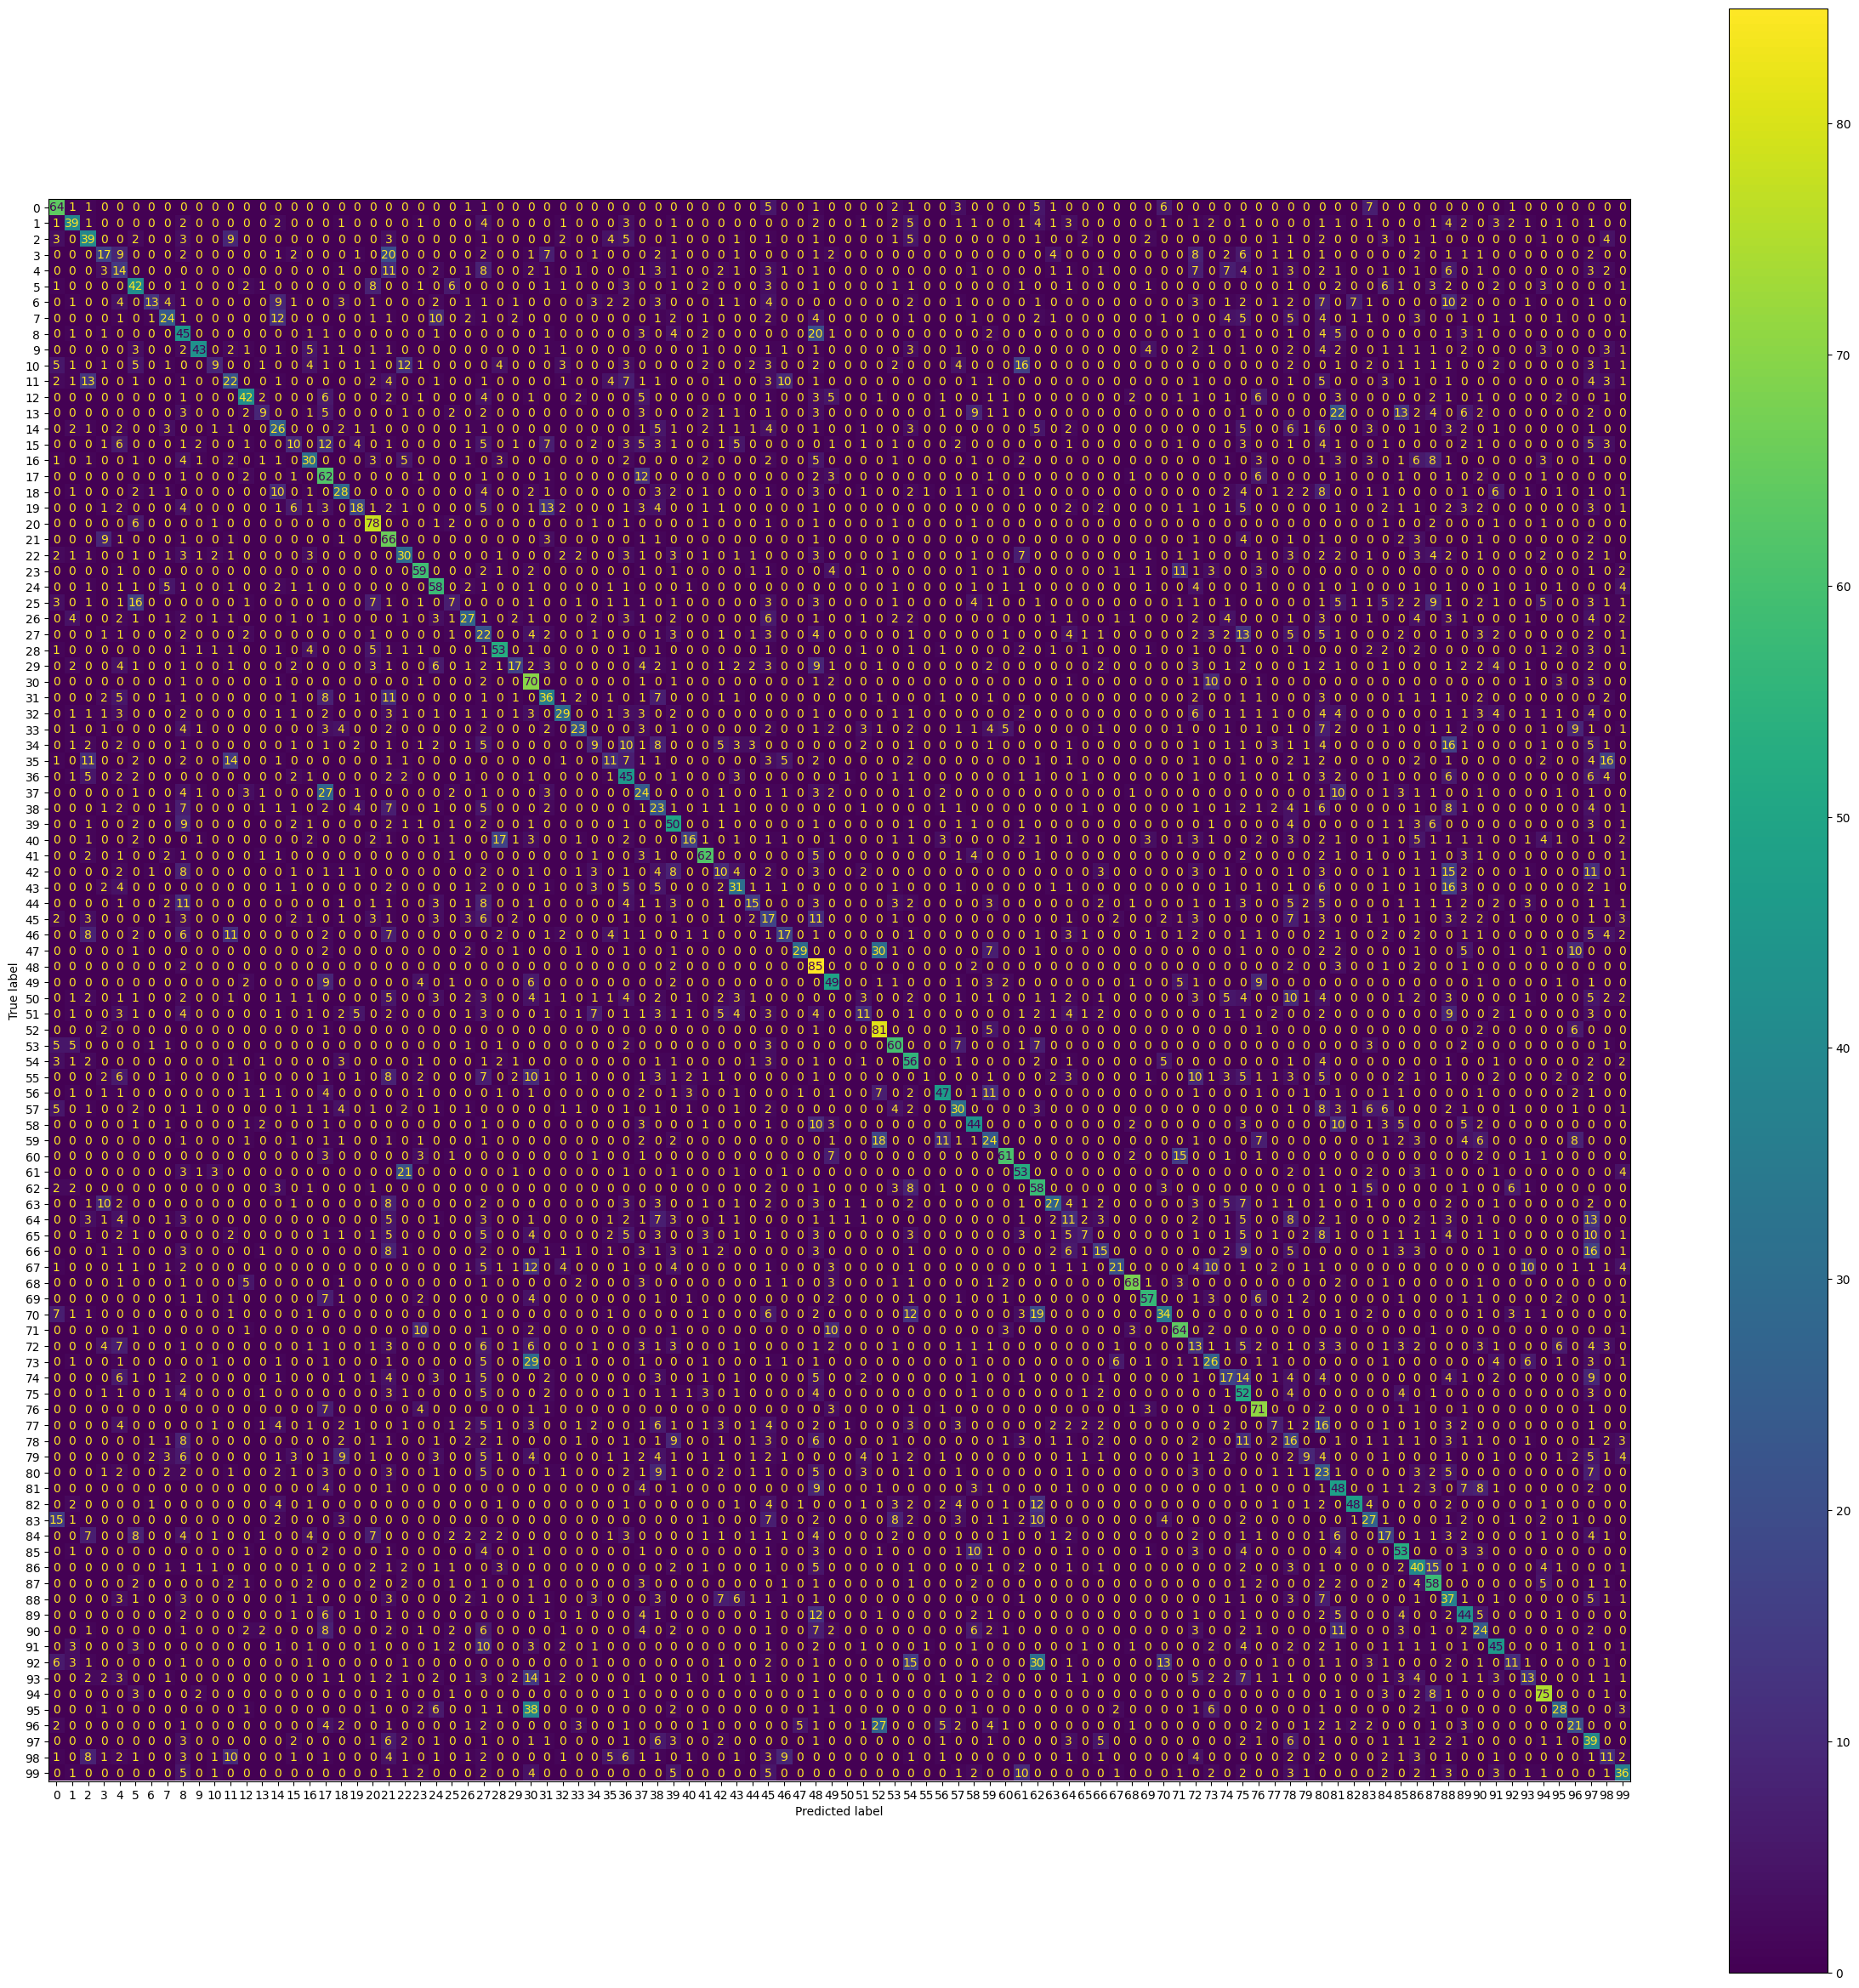

'              precision    recall  f1-score   support\n\n           0       0.48      0.64      0.55       100\n           1       0.48      0.39      0.43       100\n           2       0.32      0.39      0.35       100\n           3       0.25      0.17      0.20       100\n           4       0.11      0.14      0.13       100\n           5       0.35      0.42      0.38       100\n           6       0.62      0.13      0.21       100\n           7       0.39      0.24      0.30       100\n           8       0.21      0.45      0.29       100\n           9       0.75      0.43      0.55       100\n          10       0.38      0.09      0.15       100\n          11       0.26      0.22      0.24       100\n          12       0.58      0.42      0.49       100\n          13       0.33      0.09      0.14       100\n          14       0.27      0.26      0.27       100\n          15       0.20      0.10      0.13       100\n          16       0.41      0.30      0.34       100\n       

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
print('Using Shifted Patch Tokenization')
y_pred = vit_classifier_new.predict(x_test).argmax(axis=-1)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test.T[0]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test.T[0]))
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(ax=ax)
plt.show()
classification_report(y_test.T[0], y_pred, target_names=list(map(str,np.unique(y_test.T[0]))))

**Solution**
The confusion matrices and the scores are very similar for both the stantadr ViT and the one using shifted patch. Some of the metrics such as macro avg  recall and f1 score are slightly higher for the standard ViT, hence when the small changes in the scores are critical, we would suggest using the standard ViT, which will also decrease the computational cost because of the adidtional step of shifted patches.

*   Compare DeiT with ViT.
*   What are the differences in both the architectures.
*   What is one limitation of ViT that is overcome with a DeiT?

**Solution**

DeiT (Data-efficient Image Transformer) and ViT (Vision Transformer) are both Transformer-based architectures for computer vision tasks, but they differ in their design and performance. As mentioned previously, ViT require a big number of images, however, DeiT can perform good even on a small dataset. DeiT also utelizes advanced augmention techniques to artificially increase the datasets' size. Deit also uses knowledge distillation mechanism by using learnable tokens while the Vit doesn't. Deit also adds advanced techniques such as stochastic depth to prevent overfitting. One of the main limitation of ViT is heavy reliance on large-scale pretraining, which is solved by the distillation token that learns from a pretrained CNN teacher.




...

*   What is a SWIN Transformer?
*   How is it different from DeiT and ViT?

**Solution**

The Swin Transformer is a hierarchical Transformer  designed specifically for computer vision tasks. It utelizes window-based self-attention which reduces computational complexity and tackles the scalability issue.

The main differences from Deit and ViT is that SWIN uses hierarchical patch, window-based local self-attention, multi-scale hierarchical outputs and patch merging which reduces token count.
...

*   What is distillation?
*   Explain the distillation used in DeiT
*   What is its significance? Why do we need distillation?

**Solution**

Knowledge distillation is a model compressio technique. The whole idea is to use a big model's learn't patterns, and teach a smaller model t perform relatively similar to the big model( teacher model) while having less learnable parameters and being computationaly more efficient.

 The distillation token ysed in DeiT interacts with the attention mechanism to learn from the teacher model's predictions. Usually, the teacher model is a pretrained convolutional neural network.

 Knowledge distillation helps DeiT perform well even on smaller datasets, because the model is guided my the teacher model. This can potentially result in a better generalization compared to VeiT.
...

*   Which is better as a teacher model? A transformer based teacher of a CNN based teacher?

**Solution**

Although the most famious CNNs like ResNet, EfficientNet, and DenseNet are highly optimized for image-related tasks and have been extensively pretrained on large-scale datasets, they focus on local receptive fields. Hence, we would opt for  transformer based teacher models which are flexible across modalities. The thing is that a Transformer teacher may transfer knowledge more effectively because of the attention-based mechanisms. But, if computational resources are limited, a CNN-based teacher should be chosen for saving the resources.
...


---

# **End of P10: Vision Transformers**

This notebook is part of **Deliverable 5**

Deadline for Deliverable 5 (P10 and P11) submission in CampusVirtual is: **Monday, the 16th of December, 2024**
